In [20]:
import os
import copy
import math
import torch
from torch import nn
from tqdm.auto import tqdm
from torch.amp import autocast
from torch.nn import functional as F

import pytorch_lightning as pl
import matplotlib.pyplot as plt
import pytorch_lightning.callbacks as plc

from sklearn.datasets import make_swiss_roll
from torch.utils.data import DataLoader, random_split

In [21]:
current_path = os.getcwd()                                          # 获取当前工作目录
parent_path = os.path.dirname(current_path)                         # 获取当前工作目录的上一级目录

NUM_WORKERS = int(os.cpu_count()) - 1                               # 计算可用的CPU核心数量，用于数据加载
BATCH_SIZE = 200 if torch.cuda.is_available() else 100              # 根据CUDA的可用性选择批量大小

# 使用环境变量或默认路径，并处理用户主目录路径
DATASET_PATH = os.path.expanduser(os.environ.get("PATH_DATASETS", r'E:\PythonCode\DeepLearning\data'))

# 设置模型检查点路径，如果环境变量中没有定义，则使用默认路径"saved_models"
CHECKPOINT_PATH = os.path.expanduser(os.environ.get("PATH_CHECKPOINT", "saved_models"))

# 为了确保实验的可重复性，设置随机种子为42
# pl.seed_everything(42)

# 设置CUDA的cuDNN后台配置，确保结果的确定性
torch.backends.cudnn.deterministic = False

# 关闭cuDNN的自动寻找最优算法设置，以避免结果的不一致性
torch.backends.cudnn.benchmark = False

# 根据CUDA的可用性选择设备，优先使用GPU，否则使用CPU
if torch.cuda.is_available():
    device = torch.device(f"cuda:{torch.cuda.current_device()}")
else:
    device = torch.device("cpu")

# 设置浮点矩阵乘法精度为中等，以平衡性能和精度
torch.set_float32_matmul_precision('medium')

# 打印当前选择的设备信息
print("Device:", device)

Device: cuda:0


In [22]:
def exists(x):
    """
    检查变量x是否不为None。

    参数:
    x: 待检查的变量。

    返回:
    如果x不为None，则返回True；否则返回False。
    """
    return x is not None

def default(val, d):
    """
    如果val不为None，则返回val；否则返回默认值d或调用d的结果。

    参数:
    val: 待检查的变量。
    d: 默认值或可调用对象。

    返回:
    val（如果它不为None），否则返回d的调用结果或d本身。
    """
    if exists(val):
        return val
    return d() if callable(d) else d


def identity(t, *args, **kwargs):
    """
    返回输入参数t，忽略其他所有参数。

    参数:
    t: 待返回的值。
    *args: 可变参数列表。
    **kwargs: 关键字参数字典。

    返回:
    输入值t。
    """
    return t

In [23]:
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}
        self.registered_modules = set()

    def register(self, module):
        self.registered_modules.add(id(module))
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def _check_registered(self, module):
        if id(module) not in self.registered_modules:
            raise RuntimeError("Module must be registered first")

    def update(self, module):
        self._check_registered(module)
        params_to_update = [(name, param) for name, param in module.named_parameters()
                          if param.requires_grad and name in self.shadow]
        
        for name, param in params_to_update:
            self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        self._check_registered(module)
        for name, param in module.named_parameters():
            if param.requires_grad and name in self.shadow:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        self._check_registered(module)
        module_copy = copy.deepcopy(module)
        device = next(module.parameters()).device
        module_copy.to(device)
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return {
            'shadow': {k: v.clone() for k, v in self.shadow.items()},
            'mu': self.mu,
            'registered_modules': list(self.registered_modules)
        }

    def load_state_dict(self, state_dict):
        self.shadow = {k: v for k, v in state_dict['shadow'].items()}
        self.mu = state_dict['mu']
        self.registered_modules = set(state_dict['registered_modules'])

## 数据集准备

In [24]:
class SwissRollDataModule(pl.LightningDataModule):
    def __init__(
        self, 
        num_samples: int = 10**5, 
        noise: float = 0.1, 
        batch_size: int = BATCH_SIZE,
        num_workers: int = NUM_WORKERS,
    ):
        super().__init__()
        self.num_samples = num_samples
        self.noise = noise
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        # Generate Swiss roll dataset
        swiss_roll, _ = make_swiss_roll(self.num_samples, noise=self.noise)
        swiss_roll = swiss_roll[:, [0, 2]] / 10.0

        self.dataset = torch.tensor(swiss_roll, dtype=torch.float32)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset, self.val_dataset = random_split(self.dataset, [0.8, 0.2])

        if stage == "test" or stage == "validate":
            self.train_dataset, self.val_dataset = random_split(self.dataset, [0.8, 0.2])
            self.test_dataset = self.val_dataset

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, drop_last=True, persistent_workers=True, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, drop_last=True, persistent_workers=True, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, drop_last=True, persistent_workers=True, pin_memory=True)

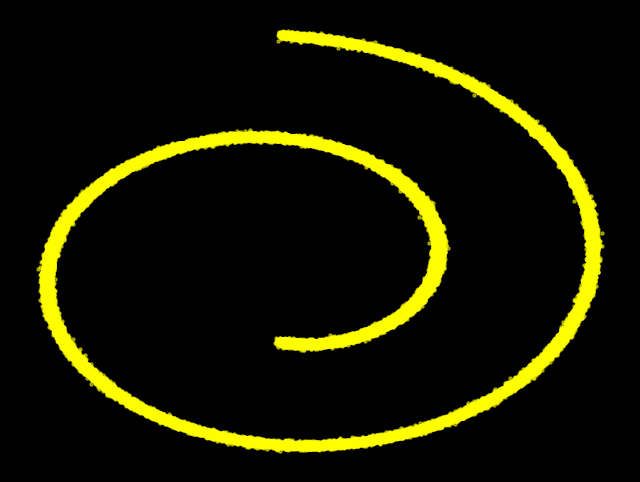

In [25]:
test_module = SwissRollDataModule()
test_module.prepare_data()
test_module.setup()

fig, axes = plt.subplots(1, 1, figsize=(8, 6), facecolor='black')  # 设置背景为黑色
axes.scatter(*test_module.dataset.T, alpha=0.5, s=5, color='yellow')  # 设置散点为黄色
axes.axis('off')
plt.show()

In [26]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out

In [27]:
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)

In [28]:
def linear_beta_schedule(timesteps):
    """
    Linear schedule for beta values, as proposed in the original DDPM paper.
    
    Parameters:
        timesteps (int): Number of timesteps.
        
    Returns:
        torch.Tensor: Beta values scheduled linearly.
    """
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float64)

def cosine_beta_schedule(timesteps, s=0.008):
    """
    Cosine schedule for beta values, as proposed in https://openreview.net/forum?id=-NEXDKk8gZ.
    
    Parameters:
        timesteps (int): Number of timesteps.
        s (float): Small shift to avoid division by zero.
        
    Returns:
        torch.Tensor: Beta values scheduled using a cosine function.
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype=torch.float64) / timesteps
    alphas_cumprod = torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)

def sigmoid_beta_schedule(timesteps, start=-5, end=5, tau=1, clamp_min=1e-5):
    """
    Sigmoid schedule for beta values, proposed in https://arxiv.org/abs/2212.11972 - Figure 8.
    This schedule is better suited for images larger than 64x64 when used during training.
    
    Parameters:
        timesteps (int): Number of timesteps.
        start (float): Starting value before sigmoid transformation.
        end (float): Ending value before sigmoid transformation.
        tau (float): Temperature for sigmoid transformation.
        clamp_min (float): Minimum value to clamp betas to avoid numerical instability.
        
    Returns:
        torch.Tensor: Beta values scheduled using a sigmoid function.
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype=torch.float64) / timesteps
    v_start = torch.tensor(start / tau).sigmoid()
    v_end = torch.tensor(end / tau).sigmoid()
    alphas_cumprod = (-((t * (end - start) + start) / tau).sigmoid() + v_end) / (v_end - v_start)
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


# def sigmoid_beta_schedule(timesteps, start=-6, end=6):

#     betas = torch.linspace(start, end, timesteps)
#     betas = torch.sigmoid(betas) * (end - start) + start

#     return betas

## 高斯扩散训练器类

In [29]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

In [30]:
class GaussianDiffusion(pl.LightningModule):
    def __init__(
        self,
        model,
        *,
        timesteps = 1000,
        sampling_timesteps = None,
        objective = 'pred_noise',
        beta_schedule = 'sigmoid',
        schedule_fn_kwargs = dict(),
        ema_decay=0.999,  # 添加EMA decay参数
        use_ema=True,     # 添加是否使用EMA的标志
    ):
        super().__init__()

        self.model = model
        self.objective = objective
        self.use_ema = use_ema  # 是否使用EMA
      
        # 确保目标函数合法
        assert objective in {'pred_noise', 'pred_x0', 'pred_v'}

        # 辅助函数，用于从float64到float32的缓冲区注册
        register_buffer = lambda name, val: self.register_buffer(name, val.to(torch.float32))
        
        # 根据beta调度策略选择相应的调度函数
        if beta_schedule == 'linear':
            beta_schedule_fn = linear_beta_schedule
        elif beta_schedule == 'cosine':
            beta_schedule_fn = cosine_beta_schedule
        elif beta_schedule == 'sigmoid':
            beta_schedule_fn = sigmoid_beta_schedule
        else:
            raise ValueError(f'unknown beta schedule {beta_schedule}')
        
        betas = beta_schedule_fn(timesteps, **schedule_fn_kwargs).float()

        timesteps, = betas.shape
        self.num_timesteps = int(timesteps)

        alphas = 1 - betas
        alphas_prod = torch.cumprod(alphas, dim=0)
        alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)

        register_buffer('alphas', alphas)
        register_buffer('betas', betas)
        register_buffer('alphas_prod', alphas_prod)
        register_buffer('alphas_prod_p', alphas_prod_p)

        # 扩散过程q(x_t | x_{t-1})和其他过程的计算
        register_buffer('alphas_bar_sqrt', torch.sqrt(alphas_prod))
        register_buffer('one_minus_alphas_bar_sqrt', torch.sqrt(1. - alphas_prod))
        register_buffer('one_minus_alphas_bar_log', torch.log(1. - alphas_prod))

        register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1. / alphas_prod))
        register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1. / alphas_prod - 1))

        # 后验q(x_{t-1} | x_t, x_0)的计算
        posterior_variance = betas * (1. - alphas_prod_p) / (1. - alphas_prod)
        register_buffer('posterior_variance', posterior_variance)
        register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min =1e-20)))
        register_buffer('posterior_mean_coef1', betas * torch.sqrt(alphas_prod_p) / (1. - alphas_prod))
        register_buffer('posterior_mean_coef2', (1. - alphas_prod_p) * torch.sqrt(alphas) / (1. - alphas_prod))

        # 采样相关参数
        self.sampling_timesteps = default(sampling_timesteps, timesteps) # 默认采样时间步数等于训练时的时间步数

        # 初始化EMA
        if self.use_ema:
            self.ema = EMA(mu=ema_decay)
            self.ema.register(self.model)
            # 创建一个EMA模型的副本用于评估和采样
            self.ema_model = copy.deepcopy(self.model)
            self.ema.register(self.ema_model)


    @property
    def device(self):
        return self.betas.device
    
    @autocast('cuda', enabled = False)
    def q_x(self, x_0, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_0))

        alphas_t = extract(self.alphas_bar_sqrt, t, x_0)
        alphas_1_m_t = extract(self.one_minus_alphas_bar_sqrt, t, x_0)
        return (alphas_t * x_0 + alphas_1_m_t * noise)
    
    def forward(self, x_start, t):
        # 在推理期间使用EMA模型，训练期间使用普通模型
        if not self.training and self.use_ema:
            return self.ema_model(x_start, t)
        return self.model(x_start, t)
       
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.num_timesteps/10)
        return [optimizer]
   
    def training_step(self, batch, batch_idx):

        # Compute the loss.
        batch_x_size = batch.shape[0]

        t = torch.randint(0, self.num_timesteps, (batch_x_size,), device=self.device).long()

        # x0 multiplier
        a = extract(self.alphas_bar_sqrt, t, batch)
        # eps multiplier
        am1 = extract(self.one_minus_alphas_bar_sqrt, t, batch)
        e = torch.randn_like(batch, device=self.device)
        # model input
        x = batch * a + e * am1

        output = self.forward(x, t)

        loss = F.mse_loss(output, e)    # (e-output).square().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("lr", self.optimizers().param_groups[0]['lr'], prog_bar=True)  # 添加学习率记录

        # 在训练步骤结束后更新EMA模型
        if self.use_ema:
            self.ema.update(self.model)

        return loss

    def on_validation_epoch_start(self):
        # 在验证前将EMA权重应用到EMA模型
        if self.use_ema:
            self.ema.ema(self.ema_model)
    
    def validation_step(self, batch, batch_idx):
        # Compute the loss.
        batch_x_size = batch.shape[0]

        t = torch.randint(0, self.num_timesteps, (batch_x_size,), device=self.device).long()

        # x0 multiplier
        a = extract(self.alphas_bar_sqrt, t, batch)
        # eps multiplier
        am1 = extract(self.one_minus_alphas_bar_sqrt, t, batch)
        e = torch.randn_like(batch, device=self.device)
        # model input
        x = batch * a + e * am1

        output = self.forward(x, t)

        loss = F.mse_loss(output, e)    # (e-output).square().mean()
        self.log("val_loss", loss, prog_bar=True)
    
    def p_mean_variance(self, x, t, clip_denoised = False):
        preds_noise = self.model(x, t)
        x_start = extract(self.sqrt_recip_alphas_cumprod, t, x) * x - extract(self.sqrt_recipm1_alphas_cumprod, t, x) * preds_noise

        if clip_denoised:
            x_start.clamp_(-1., 1.)

        posterior_variance = extract(self.posterior_variance, t, x)
        posterior_log_variance = extract(self.posterior_log_variance_clipped, t, x)

        model_mean = extract(self.posterior_mean_coef1, t, x) * x_start + extract(self.posterior_mean_coef2, t, x) * x

        return model_mean, posterior_variance, posterior_log_variance, x_start
    
    
    @torch.inference_mode()
    def p_sample(self, x, t):
        t = torch.tensor([t], device=self.device)

        model_mean, _, model_log_variance, x_start = self.p_mean_variance(x, t)

        noise = torch.randn_like(x) if t > 0 else 0.    # t=0时，噪声为0

        sample = model_mean + torch.exp(0.5 * model_log_variance) * noise

        return sample
  
    @torch.inference_mode()
    def p_sample_loop(self, shape):
        # 如果使用EMA，确保在采样前应用EMA权重
        if self.use_ema:
            self.ema.ema(self.ema_model)

        cur_x = torch.randn(shape)
        yield cur_x
        for i in tqdm(reversed(range(0, self.num_timesteps)), desc='sampling loop time step', total=self.num_timesteps):
            cur_x = self.p_sample(cur_x, i)
            yield cur_x
    
    def on_save_checkpoint(self, checkpoint):
        # 保存EMA状态
        if self.use_ema:
            checkpoint['ema'] = self.ema.state_dict()
            
    def on_load_checkpoint(self, checkpoint):
        # 加载EMA状态
        if self.use_ema and 'ema' in checkpoint:
            self.ema.load_state_dict(checkpoint['ema'])
            # 应用EMA权重到EMA模型
            self.ema.ema(self.ema_model)

## 训练

In [31]:
def load_callbacks():
    callbacks = []

    callbacks.append(plc.EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=10,
        min_delta=0.001
    ))

    callbacks.append(plc.ModelCheckpoint(
        monitor='val_loss',
        filename='{epoch:02d}-{val_loss:.3f}',
        save_top_k=3,
        mode='min',
        save_last=True
    ))

    callbacks.append(plc.LearningRateMonitor(
            logging_interval='epoch'))
    
    return callbacks

In [32]:
epochs = 100
n_steps = 100
num_samples = 10**5

model = ConditionalModel(n_steps=n_steps).to(device=device)
diffusion = GaussianDiffusion(model, timesteps=n_steps, ema_decay=0.9, use_ema=True)

dm = SwissRollDataModule(num_samples=num_samples)

trainer = pl.Trainer(
    default_root_dir=CHECKPOINT_PATH,
    accelerator='auto',
    max_epochs=epochs,
    check_val_every_n_epoch=5,
    callbacks=load_callbacks(),
    gradient_clip_val=1,
    gradient_clip_algorithm='norm'
)

trainer.fit(model=diffusion, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | ConditionalModel | 72.1 K | train
1 | ema_model | ConditionalModel | 72.1 K | train
-------------------------------------------------------
144 K     Trainable params
0         Non-trainable params
144 K     Total params
0.577     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\lizx\AppData\Local\Temp\ipykernel_25792\1298111463.py:5: SyntaxWarning: invalid escape sequence '\m'
  axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$', color='white')


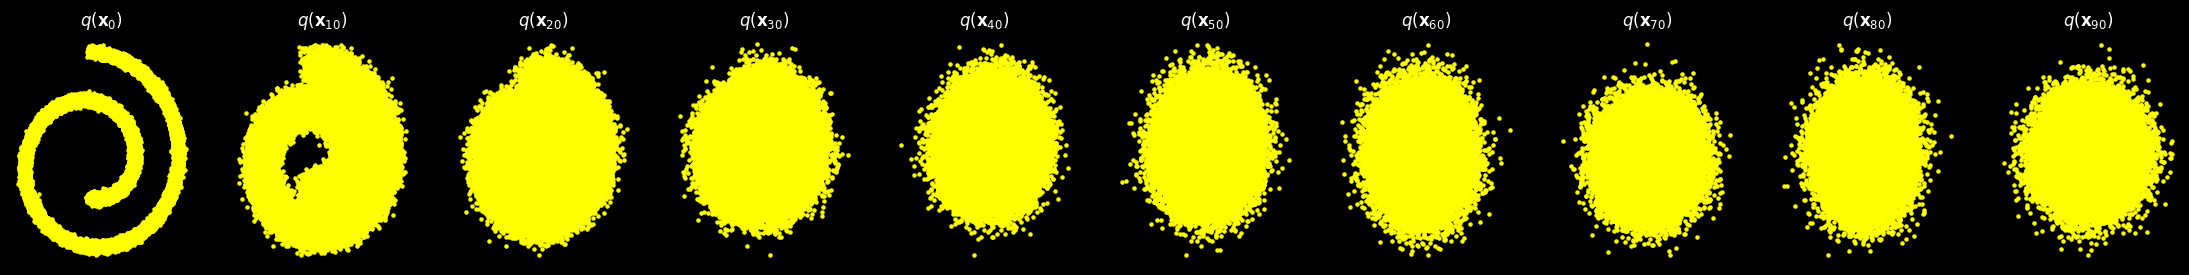

In [33]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3), facecolor='black')
for i in range(10):
    q_i = diffusion.q_x(test_module.dataset, torch.tensor([i * 10]))
    axs[i].scatter(q_i[:, 0], q_i[:, 1],color='yellow', s=5)
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$', color='white')

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
C:\Users\lizx\AppData\Local\Temp\ipykernel_25792\1752999339.py:9: SyntaxWarning: invalid escape sequence '\m'
  axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$', color='white')


sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

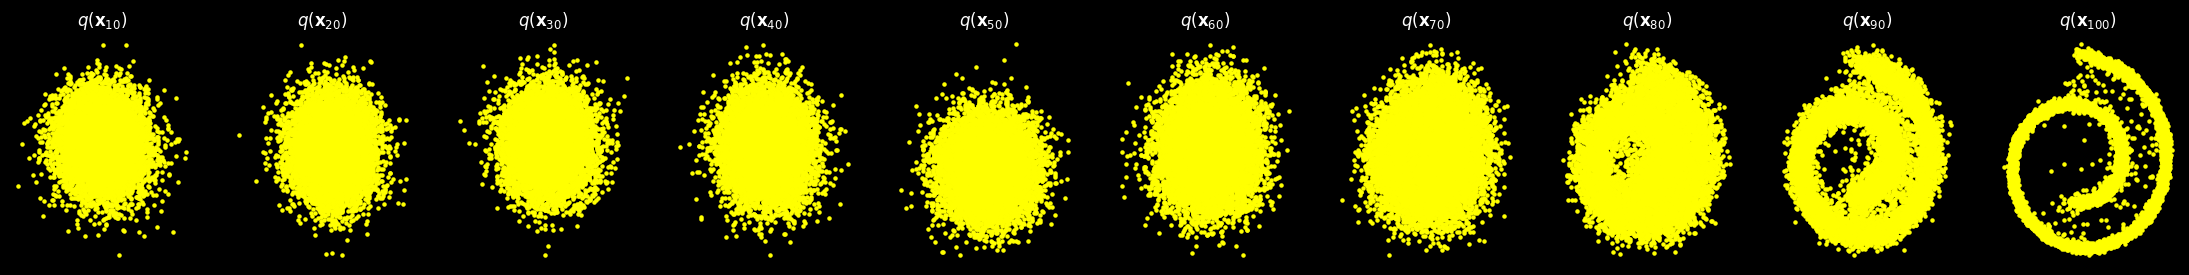

In [34]:
sampled_datas_gen = diffusion.p_sample_loop(shape=(10**4, 2))
sampled_datas = list(sampled_datas_gen)

fig, axs = plt.subplots(1, 10, figsize=(28, 3), facecolor='black')
for i in range(1, 11):
    cur_x = sampled_datas[i * 10].detach()
    axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], color='yellow', s=5)
    axs[i-1].set_axis_off()
    axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$', color='white')

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

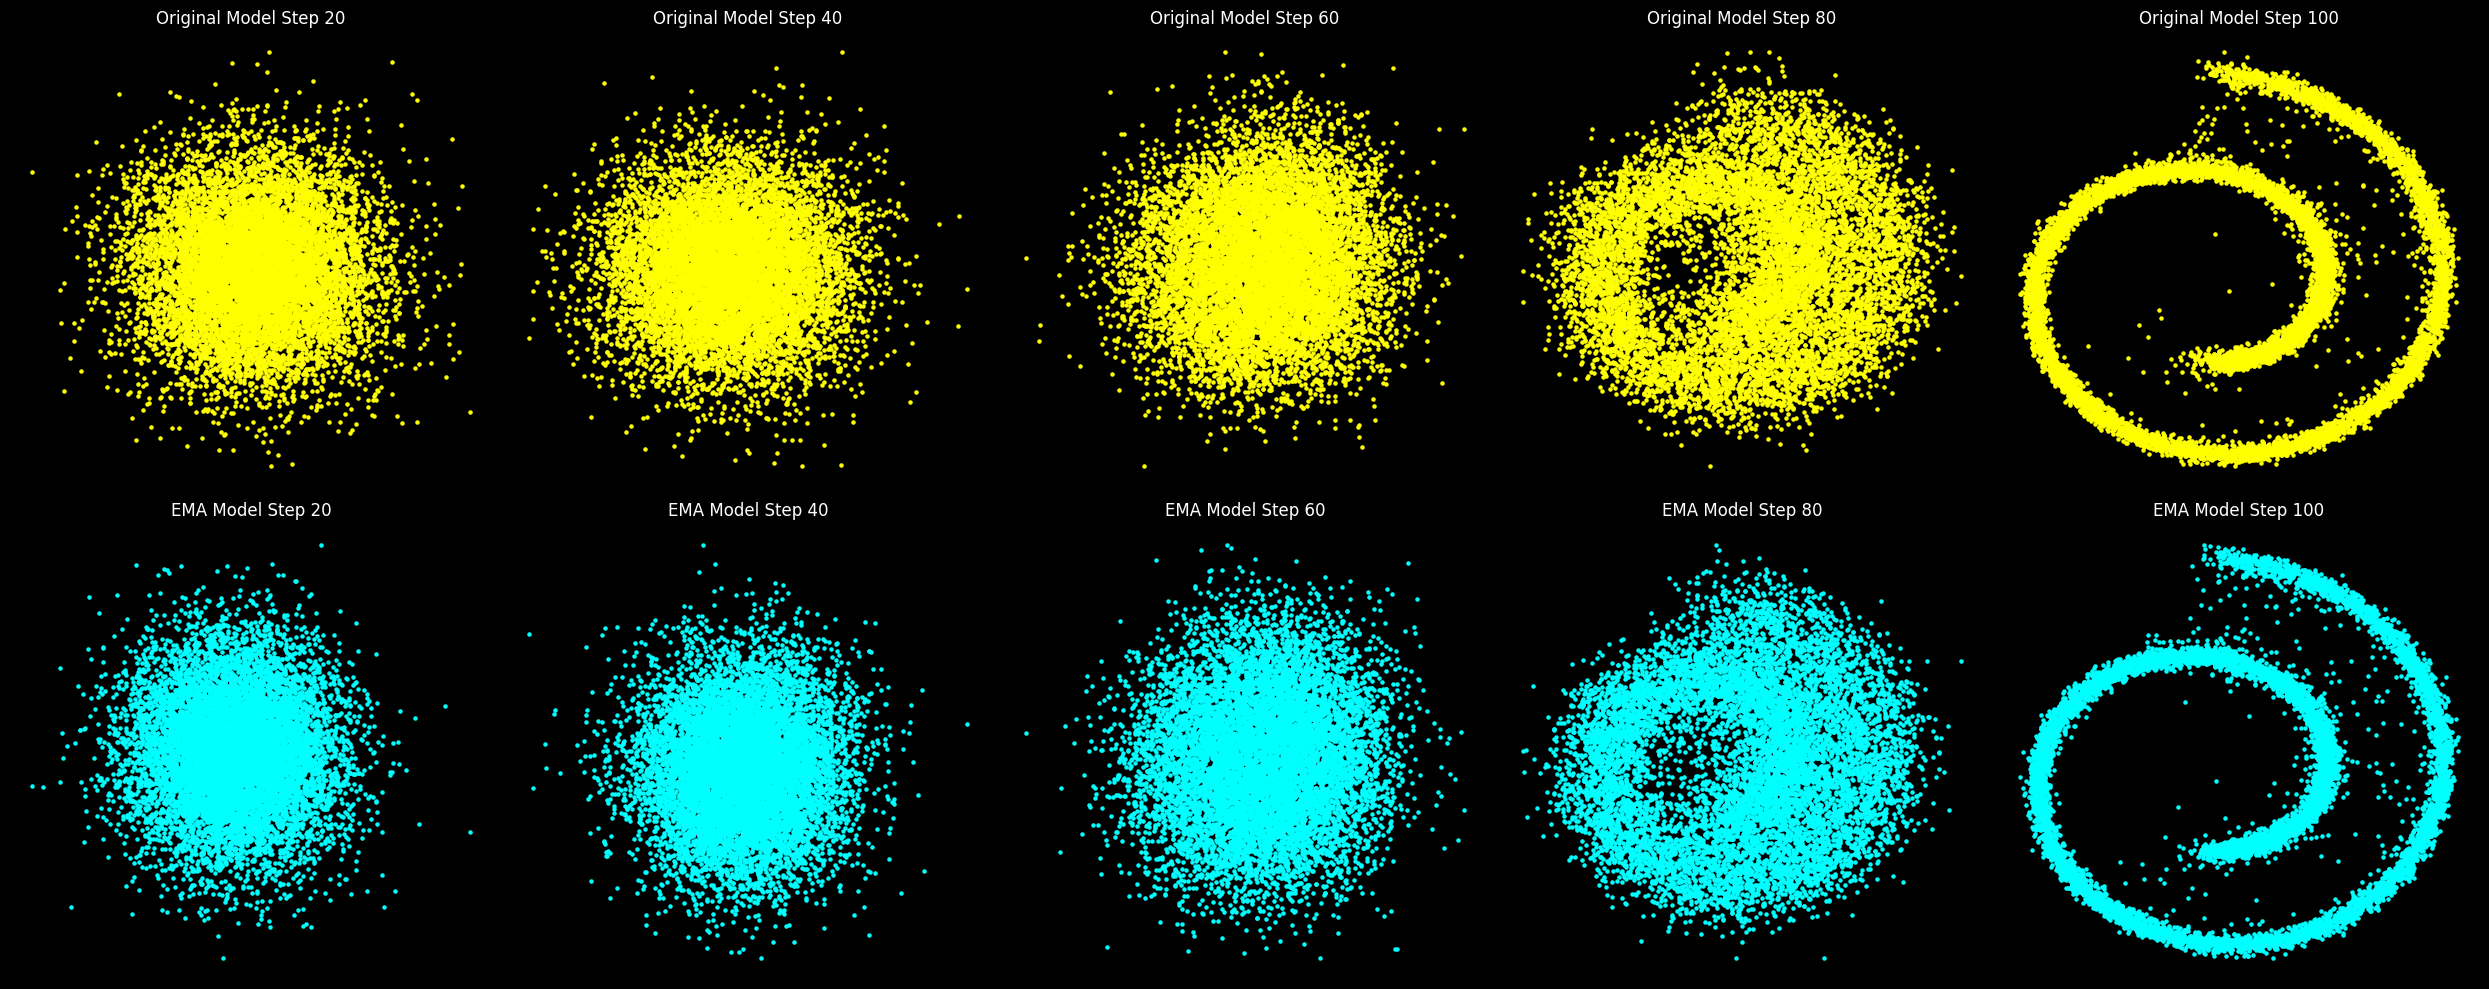

In [35]:
# 使用EMA模型进行采样
diffusion.use_ema = True
sampled_datas_ema_gen = diffusion.p_sample_loop(shape=(10**4, 2))
sampled_datas_ema = list(sampled_datas_ema_gen)

# 使用原始模型进行采样
diffusion.use_ema = False
sampled_datas_orig_gen = diffusion.p_sample_loop(shape=(10**4, 2))
sampled_datas_orig = list(sampled_datas_orig_gen)

# 可视化比较结果
fig, axs = plt.subplots(2, 5, figsize=(25, 10), facecolor='black')
steps_to_show = [n_steps // 5 * i for i in range(1, 6)]

for i, step in enumerate(steps_to_show):
    # 显示原始模型结果
    cur_x_orig = sampled_datas_orig[step].detach().cpu()
    axs[0, i].scatter(cur_x_orig[:, 0], cur_x_orig[:, 1], color='yellow', s=5)
    axs[0, i].set_axis_off()
    axs[0, i].set_title(f'Original Model Step {step}', color='white')
    
    # 显示EMA模型结果
    cur_x_ema = sampled_datas_ema[step].detach().cpu()
    axs[1, i].scatter(cur_x_ema[:, 0], cur_x_ema[:, 1], color='cyan', s=5)
    axs[1, i].set_axis_off()
    axs[1, i].set_title(f'EMA Model Step {step}', color='white')

plt.tight_layout()
plt.show()

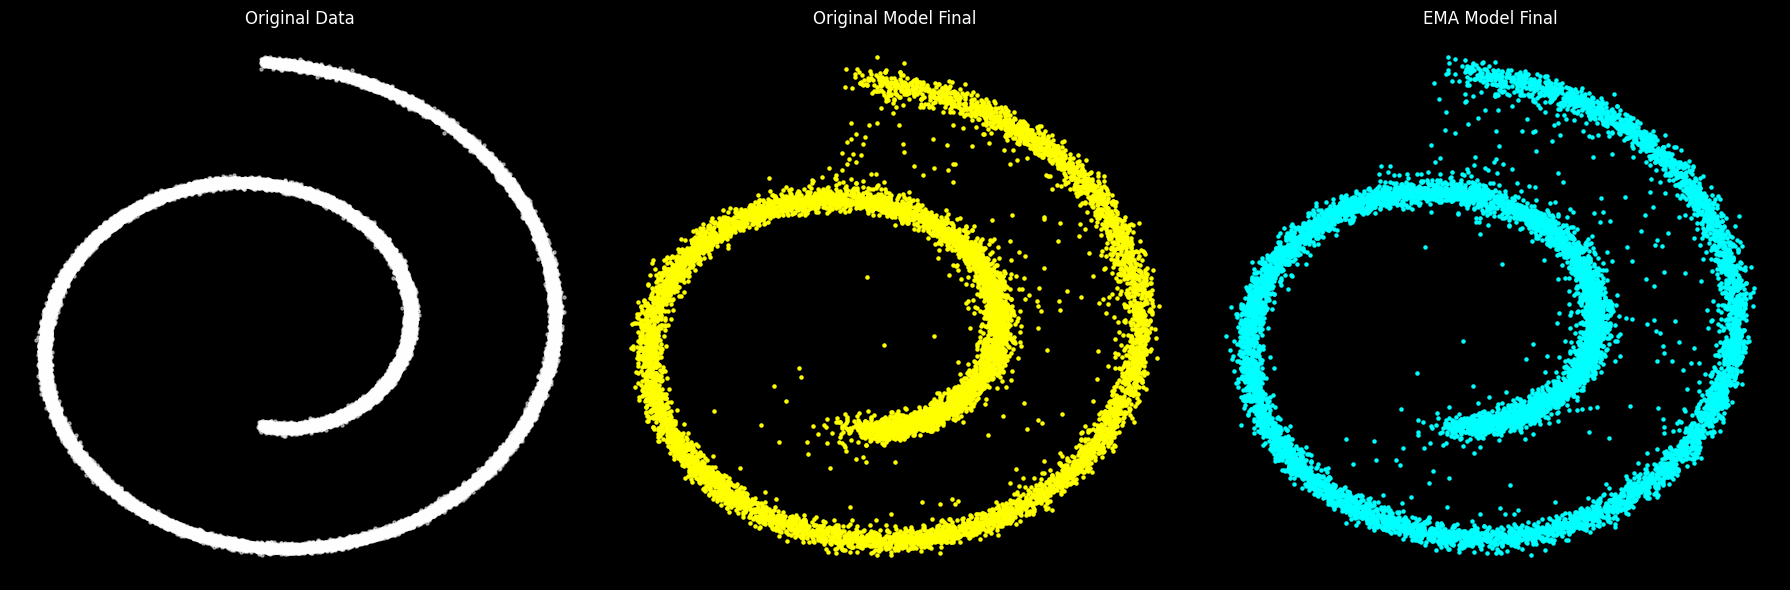

In [36]:
# 比较最终结果
fig, axs = plt.subplots(1, 3, figsize=(18, 6), facecolor='black')

# 显示真实数据
axs[0].scatter(*test_module.dataset.T, alpha=0.5, s=5, color='white')
axs[0].set_axis_off()
axs[0].set_title('Original Data', color='white')

# 显示原始模型最终结果
final_x_orig = sampled_datas_orig[-1].detach().cpu()
axs[1].scatter(final_x_orig[:, 0], final_x_orig[:, 1], color='yellow', s=5)
axs[1].set_axis_off()
axs[1].set_title('Original Model Final', color='white')

# 显示EMA模型最终结果
final_x_ema = sampled_datas_ema[-1].detach().cpu()
axs[2].scatter(final_x_ema[:, 0], final_x_ema[:, 1], color='cyan', s=5)
axs[2].set_axis_off()
axs[2].set_title('EMA Model Final', color='white')

plt.tight_layout()
plt.show()

In [37]:
%load_ext tensorboard